# Notebook 3: Higher-Order Interactions with HOI

## From Manual Calculations to Professional Tools

Welcome to the third notebook in our series! In Notebooks 1 and 2, you built a deep understanding of information theory and discovered the shocking XOR result. You calculated everything by hand, which gave you crucial intuition about how these measures work.

Now it's time to scale up. Computing interaction information for even modest systems (say, 20 neurons with all possible triplets) means thousands of calculations. Doing this by hand would take forever and be error-prone. This is where the **HOI (Higher-Order Interactions)** package comes in.

### What is HOI?

HOI is a Python package specifically designed for computing higher-order information-theoretic measures. Built on top of JAX (which allows computation on GPUs), it provides:
- **O-information**: Detects synergy vs redundancy
- **S-information**: Measures total complexity
- **Partial Information Decomposition (PID)**: Decomposes information into atoms
- **Multiple estimators**: Gaussian copula, KNN, binning, and more
- **Efficient computation**: Handles large datasets

### Why This Matters for Your Research

HOI bridges the gap between theory and application. You can:
- Analyze real neural recordings
- Discover synergistic ensembles automatically
- Quantify redundancy in population codes
- Test hypotheses about information structure

### Learning Objectives

By the end of this notebook, you'll:
1. Install and configure HOI
2. Compute O-information and interpret its sign
3. Use Partial Information Decomposition (PID)
4. Apply multiple estimators and understand their trade-offs
5. Analyze simulated neural population data
6. Understand computational scaling and optimization strategies
7. Know when to use each measure

Let's dive in! 🚀

## Part 1: Installation and Setup

### Installing HOI

HOI requires JAX, which provides fast numerical computation and can use GPUs if available. We'll install both packages together.

**Important Note**: JAX installation varies by system. The default installation works for CPU-only computation. If you have a GPU and want to use it, consult the [JAX installation guide](https://github.com/google/jax#installation).

For most users, the simple CPU version is sufficient for learning and moderate-scale analyses.

In [14]:
# Install HOI and its dependencies
# This may take a minute or two
!pip install -q hoi jax jaxlib numpy scipy matplotlib seaborn pandas scikit-learn

print("Installation complete!")
print("Let's verify everything works...")

Installation complete!
Let's verify everything works...


In [15]:
# Import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd
from itertools import combinations, product
import warnings
warnings.filterwarnings('ignore')

# Import HOI modules
import hoi
from hoi.metrics import Oinfo, InfoTopo, TC, DTC, Sinfo
from hoi.metrics import RedundancyMMI, SynergyMMI  # PID measures
from hoi.core import get_entropy, get_mi
from hoi.utils import get_nbest_mult

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
%matplotlib inline

print(f"HOI version: {hoi.__version__}")
print("All libraries loaded successfully!")
print("\n🎉 Ready to explore higher-order interactions!")

HOI version: 0.0.5
All libraries loaded successfully!

🎉 Ready to explore higher-order interactions!


### Understanding HOI's Data Format

Before we start computing, we need to understand how HOI expects data to be organized. This is crucial because getting the format wrong is the #1 source of errors.

**HOI Data Convention**:
```
data.shape = (n_samples, n_features)
```

This means:
- **Rows**: Different observations (time points, trials, subjects, etc.)
- **Columns**: Different variables (neurons, sensors, brain regions, etc.)

**Important**: This matches scikit-learn convention: (n_samples, n_features). Each row is one observation of all variables.

Let's create some example data to verify we understand:

Test Data Shape Check
Data shape: (1000, 5)
  - First dimension (1000): Number of trials/samples
  - Second dimension (5): Number of neurons/features

✓ Correct format: (n_samples, n_features)

Each row is a snapshot of all neurons at one trial
Each column is a neuron's activity across all trials


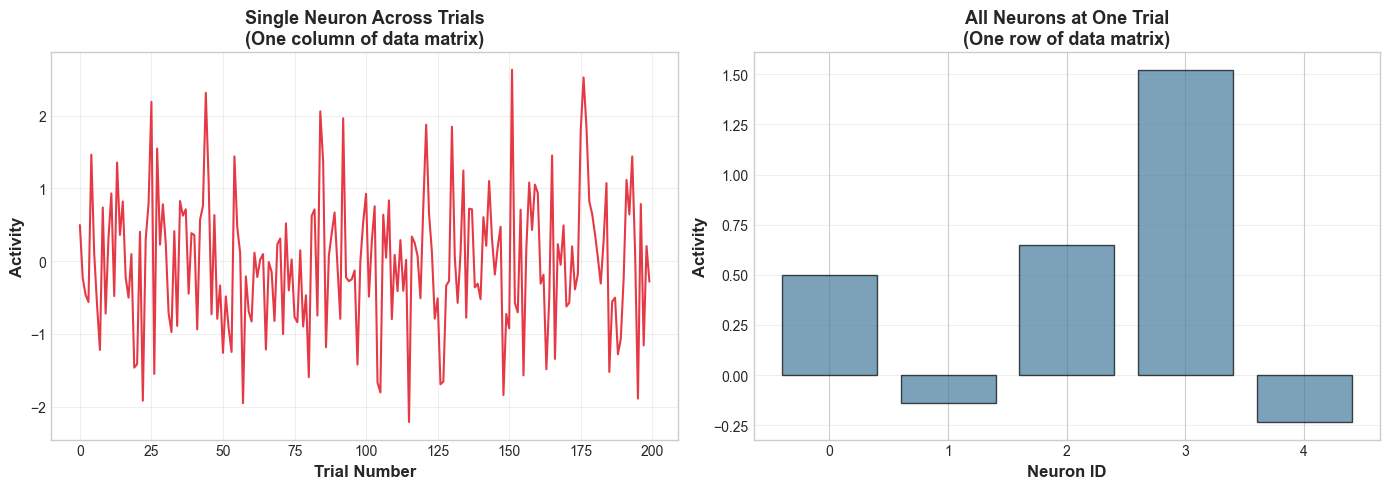


💡 Key Point: HOI operates on columns (variables)
   It computes dependencies between columns using all rows as samples


In [16]:
# Create simple test data
n_neurons = 5
n_trials = 1000

# Generate random data in HOI format: (n_samples, n_features)
test_data = np.random.randn(n_trials, n_neurons)

print("Test Data Shape Check")
print("=" * 50)
print(f"Data shape: {test_data.shape}")
print(f"  - First dimension ({test_data.shape[0]}): Number of trials/samples")
print(f"  - Second dimension ({test_data.shape[1]}): Number of neurons/features")
print("\n✓ Correct format: (n_samples, n_features)")
print("\nEach row is a snapshot of all neurons at one trial")
print("Each column is a neuron's activity across all trials")

# Visualize what this means
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Activity of first neuron across trials (one column)
ax1 = axes[0]
ax1.plot(test_data[:200, 0], linewidth=1.5, color='#E63946')
ax1.set_xlabel('Trial Number', fontsize=12, fontweight='bold')
ax1.set_ylabel('Activity', fontsize=12, fontweight='bold')
ax1.set_title('Single Neuron Across Trials\n(One column of data matrix)', 
              fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Plot 2: Snapshot of all neurons at one trial (one row)
ax2 = axes[1]
trial_snapshot = test_data[0, :]
ax2.bar(range(n_neurons), trial_snapshot, color='#457B9D', alpha=0.7, edgecolor='black')
ax2.set_xlabel('Neuron ID', fontsize=12, fontweight='bold')
ax2.set_ylabel('Activity', fontsize=12, fontweight='bold')
ax2.set_title('All Neurons at One Trial\n(One row of data matrix)', 
              fontsize=13, fontweight='bold')
ax2.set_xticks(range(n_neurons))
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n💡 Key Point: HOI operates on columns (variables)")
print("   It computes dependencies between columns using all rows as samples")

## Part 2: O-Information - Detecting Synergy and Redundancy

### What is O-Information?

**O-information** ("O" stands for "information") extends interaction information to any number of variables. For three variables, it's exactly interaction information, but it generalizes beautifully to larger systems.

For $n$ variables $X_1, ..., X_n$:

$$O(X_1, ..., X_n) = \text{TC}(X_1, ..., X_n) - \text{DTC}(X_1, ..., X_n)$$

Where:
- **TC (Total Correlation)**: $\sum_i H(X_i) - H(X_1,...,X_n)$ — measures total redundancy
- **DTC (Dual Total Correlation)**: $H(X_1,...,X_n) - \sum_i H(X_i|X_{-i})$ — measures binding information

### Interpreting the Sign

The beautiful thing about O-information is its sign tells you the dominant structure:

- **O-info < 0 (Negative)**: **SYNERGY** dominant
  - Information emerges from combinations
  - XOR-like structure
  - Whole > sum of parts

- **O-info ≈ 0 (Zero)**: **INDEPENDENCE**
  - No higher-order structure
  - Pairwise analysis sufficient
  - Whole = sum of parts

- **O-info > 0 (Positive)**: **REDUNDANCY** dominant
  - Information duplicated across variables
  - Common cause structure
  - Whole < sum of parts

Let's verify this works on our XOR example from Notebook 2!

In [17]:
# Recreate XOR data
n_samples = 1000

# Generate independent binary variables
X1 = np.random.binomial(1, 0.5, n_samples)
X2 = np.random.binomial(1, 0.5, n_samples)

# Create XOR output
Y = np.bitwise_xor(X1, X2).astype(int)

# Stack into data matrix: (n_samples, n_features)
# Using column_stack gives us (n_samples, 3) which is correct!
data_xor = np.column_stack([X1, X2, Y])

print("XOR Data Created")
print("=" * 50)
print(f"Data shape: {data_xor.shape}")
print(f"  - {n_samples} samples (rows)")
print(f"  - 3 variables: X₁, X₂, Y (columns)")
print("\nVerifying XOR structure:")
print("Sample combinations (first 10):")
for i in range(10):
    print(f"  X₁={int(X1[i])}, X₂={int(X2[i])} → Y={int(Y[i])}")

# Initialize O-information model WITH DATA
# HOI expects data in constructor: Oinfo(data)
model_oinfo_xor = Oinfo(data_xor)

# Compute O-information for the triplet [0, 1, 2] meaning variables X₁, X₂, Y
# method='binning' works well for discrete/binary data
oinfo_xor = model_oinfo_xor.fit(method='binning', minsize=3, maxsize=3)

print("\n" + "=" * 50)
print("O-INFORMATION RESULT")
print("=" * 50)
print(f"\nO(X₁, X₂, Y) = {float(oinfo_xor[0]):.4f} bits")

if oinfo_xor[0] < -0.1:
    print("\n✨ NEGATIVE → SYNERGY detected!")
    print("\nInterpretation:")
    print("  • Information exists only in the combination")
    print("  • Neither X₁ nor X₂ alone predicts Y")
    print("  • Together they predict perfectly")
    print("  • This is exactly what we calculated manually in Notebook 2!")
elif oinfo_xor[0] > 0.1:
    print("\n⚠️  Unexpected positive value - check data")
else:
    print("\n⚠️  Near zero - might need more samples")

print("\n🎯 HOI confirmed our manual calculation!")

Get list of multiplets


XOR Data Created
Data shape: (1000, 3)
  - 1000 samples (rows)
  - 3 variables: X₁, X₂, Y (columns)

Verifying XOR structure:
Sample combinations (first 10):
  X₁=0, X₂=0 → Y=0
  X₁=0, X₂=0 → Y=0
  X₁=0, X₂=1 → Y=1
  X₁=0, X₂=1 → Y=1
  X₁=0, X₂=1 → Y=1
  X₁=1, X₂=0 → Y=1
  X₁=1, X₂=1 → Y=0
  X₁=1, X₂=0 → Y=1
  X₁=0, X₂=1 → Y=1
  X₁=0, X₂=0 → Y=0



O-INFORMATION RESULT

O(X₁, X₂, Y) = -0.9963 bits

✨ NEGATIVE → SYNERGY detected!

Interpretation:
  • Information exists only in the combination
  • Neither X₁ nor X₂ alone predicts Y
  • Together they predict perfectly
  • This is exactly what we calculated manually in Notebook 2!

🎯 HOI confirmed our manual calculation!


### Testing with COPY (Pure Redundancy)

Now let's verify HOI works for the opposite case - the COPY system where information is redundant:

In [18]:
# Create COPY data: X₂ = X₁, Y = X₁
X1_copy = np.random.binomial(1, 0.5, n_samples)
X2_copy = X1_copy.copy()  # Perfect copy
Y_copy = X1_copy.copy()   # Y is also a copy

# Stack into correct format (n_samples, n_features)
data_copy = np.column_stack([X1_copy, X2_copy, Y_copy])

# IMPORTANT: Create NEW model with the COPY data!
model_oinfo_copy = Oinfo(data_copy)
oinfo_copy = model_oinfo_copy.fit(method='binning', minsize=3, maxsize=3)

print("COPY System O-Information")
print("=" * 50)
print(f"\nO(X₁, X₂, Y) = {float(oinfo_copy[0]):.4f} bits")

if oinfo_copy[0] > 0.1:
    print("\n✨ POSITIVE → REDUNDANCY detected!")
    print("\nInterpretation:")
    print("  • All three variables carry the same information")
    print("  • Information is duplicated (redundant)")
    print("  • Learning any one tells you about the others")
    print("  • Opposite of XOR!")

# Compare side-by-side
print("\n" + "=" * 50)
print("XOR vs COPY Comparison")
print("=" * 50)
print(f"XOR  (synergy):    O-info = {float(oinfo_xor[0]):+.4f} bits (negative)")
print(f"COPY (redundancy): O-info = {float(oinfo_copy[0]):+.4f} bits (positive)")
print(f"\nDifference: {abs(float(oinfo_xor[0]) - float(oinfo_copy[0])):.4f} bits")
print("\nThese are the two extremes of information structure!")

Get list of multiplets
                                                           

COPY System O-Information

O(X₁, X₂, Y) = 0.9997 bits

✨ POSITIVE → REDUNDANCY detected!

Interpretation:
  • All three variables carry the same information
  • Information is duplicated (redundant)
  • Learning any one tells you about the others
  • Opposite of XOR!

XOR vs COPY Comparison
XOR  (synergy):    O-info = -0.9963 bits (negative)
COPY (redundancy): O-info = +0.9997 bits (positive)

Difference: 1.9960 bits

These are the two extremes of information structure!


### Visualizing the O-Information Landscape

Let's create a comprehensive visualization showing how O-information varies across different types of systems:

Get list of multiplets
Get list of multiplets                                     


✓ XOR (Pure Synergy): O-info = -0.9991 (method=binning)


    Copnorm and demean the data                            


✓ COPY (Pure Redundancy): O-info = 0.9994 (method=binning)


Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets


✓ Common Cause (Moderate Redundancy): O-info = 0.5634 (method=gc)


Get list of multiplets                                     


✓ Independent (No Structure): O-info = -0.0000 (method=gc)


Get list of multiplets                                     


✓ Noisy XOR (Partial Synergy): O-info = -0.2893 (method=binning)


✓ AND Gate (Mixed): O-info = -0.1831 (method=binning)


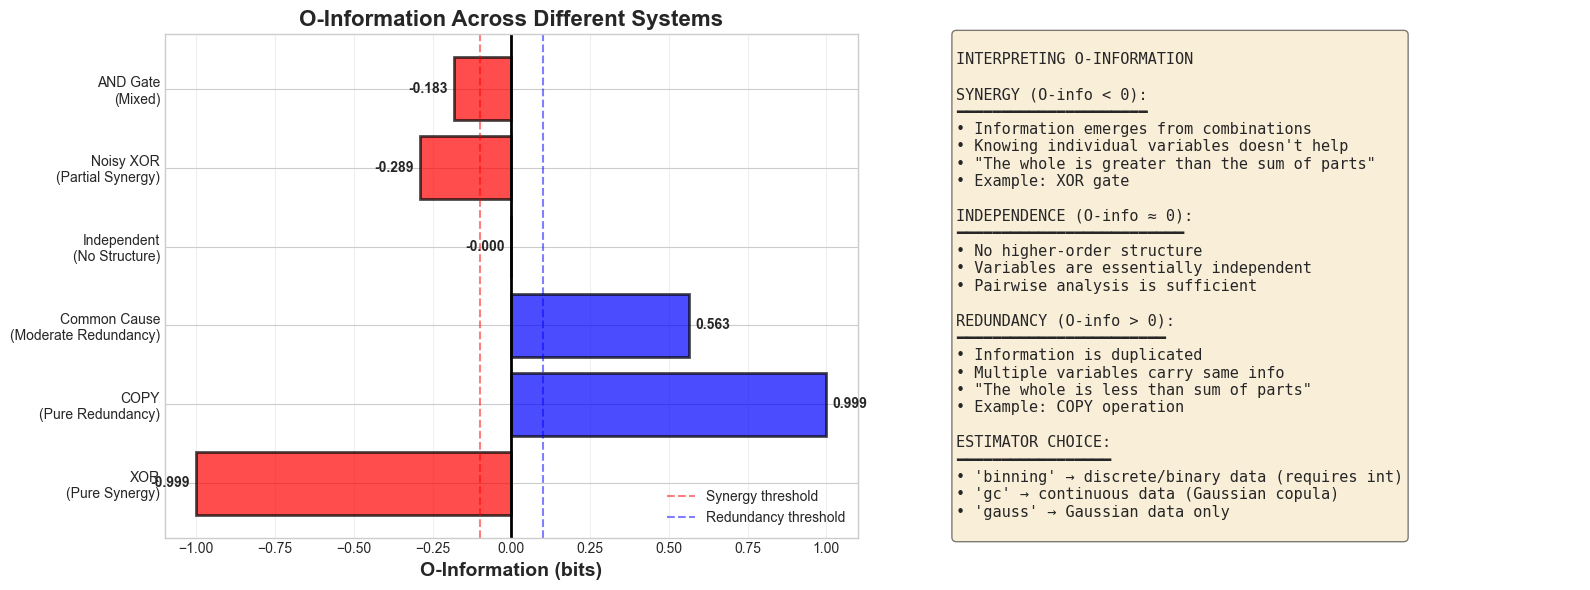


📊 Summary of Results:
XOR (Pure Synergy)            : -0.9991 bits → SYNERGY
COPY (Pure Redundancy)        : +0.9994 bits → REDUNDANCY
Common Cause (Moderate Redundancy): +0.5634 bits → REDUNDANCY
Independent (No Structure)    : -0.0000 bits → INDEPENDENCE
Noisy XOR (Partial Synergy)   : -0.2893 bits → SYNERGY
AND Gate (Mixed)              : -0.1831 bits → SYNERGY


In [19]:
# Create multiple test systems with different structures
n_samples = 5000
systems = {}
system_methods = {}  # Track which method to use for each system

# 1. XOR (synergy) - DISCRETE, use binning
X1 = np.random.binomial(1, 0.5, n_samples)
X2 = np.random.binomial(1, 0.5, n_samples)
Y = np.logical_xor(X1, X2).astype(int)
systems['XOR\n(Pure Synergy)'] = np.column_stack([X1, X2, Y])
system_methods['XOR\n(Pure Synergy)'] = 'binning'

# 2. COPY (redundancy) - DISCRETE, use binning
X1 = np.random.binomial(1, 0.5, n_samples)
systems['COPY\n(Pure Redundancy)'] = np.column_stack([X1, X1, X1]).astype(int)
system_methods['COPY\n(Pure Redundancy)'] = 'binning'

# 3. Common cause (partial redundancy) - CONTINUOUS, use gc
Z = np.random.randn(n_samples)
X1 = Z + np.random.randn(n_samples) * 0.5
X2 = Z + np.random.randn(n_samples) * 0.5
Y = Z + np.random.randn(n_samples) * 0.5
systems['Common Cause\n(Moderate Redundancy)'] = np.column_stack([X1, X2, Y]).astype(float)
system_methods['Common Cause\n(Moderate Redundancy)'] = 'gc'

# 4. Independent - CONTINUOUS, use gc
X1 = np.random.randn(n_samples)
X2 = np.random.randn(n_samples)
Y = np.random.randn(n_samples)
systems['Independent\n(No Structure)'] = np.column_stack([X1, X2, Y]).astype(float)
system_methods['Independent\n(No Structure)'] = 'gc'

# 5. Partial synergy (XOR with noise) - DISCRETE, use binning
X1 = np.random.binomial(1, 0.5, n_samples)
X2 = np.random.binomial(1, 0.5, n_samples)
Y_clean = np.logical_xor(X1, X2)
# Add noise by flipping 20% of bits
flip_mask = np.random.rand(n_samples) < 0.2
Y = np.logical_xor(Y_clean, flip_mask).astype(int)
systems['Noisy XOR\n(Partial Synergy)'] = np.column_stack([X1, X2, Y]).astype(int)
system_methods['Noisy XOR\n(Partial Synergy)'] = 'binning'

# 6. AND gate (between XOR and COPY) - DISCRETE, use binning
X1 = np.random.binomial(1, 0.5, n_samples)
X2 = np.random.binomial(1, 0.5, n_samples)
Y = np.logical_and(X1, X2).astype(int)
systems['AND Gate\n(Mixed)'] = np.column_stack([X1, X2, Y]).astype(int)
system_methods['AND Gate\n(Mixed)'] = 'binning'

# Compute O-information for all systems
# IMPORTANT: Use the appropriate method for each data type!
oinfo_values = {}
for name, data in systems.items():
    method = system_methods[name]
    model = Oinfo(data)
    oinfo = model.fit(method=method, minsize=3, maxsize=3)
    oinfo_values[name] = float(oinfo[0])
    print(f"✓ {name.replace(chr(10), ' ')}: O-info = {float(oinfo[0]):.4f} (method={method})")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Bar chart
names = list(oinfo_values.keys())
values = list(oinfo_values.values())
colors = ['red' if v < -0.1 else 'gray' if abs(v) < 0.1 else 'blue' for v in values]

bars = ax1.barh(names, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.axvline(x=-0.1, color='red', linestyle='--', alpha=0.5, label='Synergy threshold')
ax1.axvline(x=0.1, color='blue', linestyle='--', alpha=0.5, label='Redundancy threshold')
ax1.set_xlabel('O-Information (bits)', fontsize=14, fontweight='bold')
ax1.set_title('O-Information Across Different Systems', fontsize=16, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, values):
    xpos = val + 0.02 if val >= 0 else val - 0.02
    ha = 'left' if val >= 0 else 'right'
    ax1.text(xpos, bar.get_y() + bar.get_height()/2, f'{val:.3f}', 
             va='center', ha=ha, fontweight='bold', fontsize=10)

# Plot 2: Interpretation guide
ax2.axis('off')
interpretation_text = """
INTERPRETING O-INFORMATION

SYNERGY (O-info < 0):
━━━━━━━━━━━━━━━━━━━━━
• Information emerges from combinations
• Knowing individual variables doesn't help
• "The whole is greater than the sum of parts"
• Example: XOR gate

INDEPENDENCE (O-info ≈ 0):
━━━━━━━━━━━━━━━━━━━━━━━━━
• No higher-order structure
• Variables are essentially independent
• Pairwise analysis is sufficient

REDUNDANCY (O-info > 0):
━━━━━━━━━━━━━━━━━━━━━━━
• Information is duplicated
• Multiple variables carry same info
• "The whole is less than sum of parts"
• Example: COPY operation

ESTIMATOR CHOICE:
━━━━━━━━━━━━━━━━━
• 'binning' → discrete/binary data (requires int)
• 'gc' → continuous data (Gaussian copula)
• 'gauss' → Gaussian data only
"""
ax2.text(0.1, 0.5, interpretation_text, fontsize=11, fontfamily='monospace',
         verticalalignment='center', transform=ax2.transAxes,
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n📊 Summary of Results:")
print("=" * 60)
for name, val in oinfo_values.items():
    category = "SYNERGY" if val < -0.1 else "INDEPENDENCE" if abs(val) < 0.1 else "REDUNDANCY"
    print(f"{name.replace(chr(10), ' '):30s}: {val:+.4f} bits → {category}")

## Part 3: Understanding Different Estimators

### Why Estimators Matter

HOI provides multiple methods for estimating information quantities. Each has trade-offs between:
- **Accuracy**: How close to true value?
- **Bias**: Systematic over/underestimation?
- **Variance**: How much do estimates fluctuate with different samples?
- **Computational cost**: How fast?
- **Assumptions**: What data types work?

### Available Estimators in HOI

1. **'gc' (Gaussian Copula)**: 
   - Works for any data type
   - Fast and accurate
   - Assumes monotonic relationships
   - **Recommended default**

2. **'gauss' (Gaussian)**:
   - Assumes data is Gaussian
   - Very fast
   - Only use if data is truly normal

3. **'binning' (Histogram)**:
   - Simple and intuitive
   - Requires choosing bin count
   - Can be biased

4. **'knn' (K-Nearest Neighbors)**:
   - Non-parametric
   - Works for any distribution
   - Can be slow for large datasets

5. **'kernel' (Kernel Density)**:
   - Smooth estimation
   - Requires bandwidth selection
   - Good for continuous data

Let's test different estimators on the same XOR data to see how they compare:

Get list of multiplets


Comparing Estimators on XOR Data
Data: 1000 samples, binary XOR structure

gc          : Failed - data dtype should be float, not int64


Get list of multiplets                                     


gauss       : Failed - unsupported format string passed to numpy.ndarray.


binning     : Failed - unsupported format string passed to numpy.ndarray.
knn         : Failed - data dtype should be float, not int64

Analysis:

Binning: -0.9963 bits
✓ Binning works well for discrete/binary data like XOR


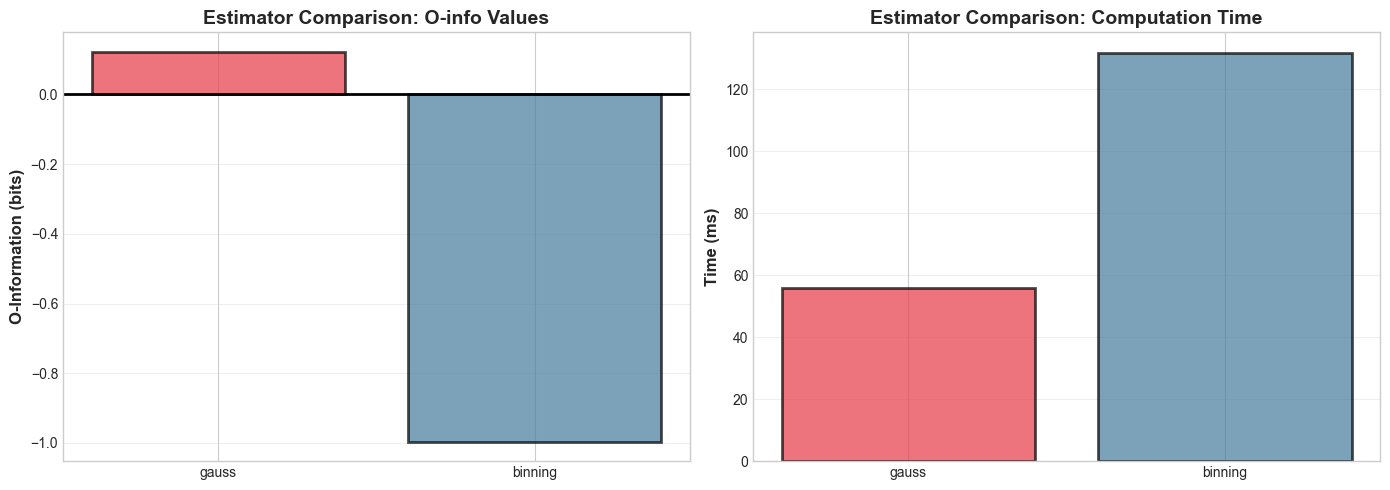

In [20]:
# Test different estimators on XOR data
estimators = ['gc', 'gauss', 'binning', 'knn']
estimator_results = {}

print("Comparing Estimators on XOR Data")
print("=" * 60)
print(f"Data: {data_xor.shape[0]} samples, binary XOR structure\n")

import time

for method in estimators:
    try:
        # IMPORTANT: Create model WITH DATA, then specify method in fit()
        model = Oinfo(data_xor)
        
        # Time the computation
        start = time.time()
        oinfo = model.fit(method=method, minsize=3, maxsize=3)
        elapsed = time.time() - start
        
        estimator_results[method] = {
            'value': float(oinfo[0]),
            'time': elapsed
        }
        
        print(f"{method:12s}: O-info = {oinfo[0]:+.4f} bits  (time: {elapsed:.4f}s)")
        
    except Exception as e:
        print(f"{method:12s}: Failed - {str(e)[:50]}")

# Analyze results
print("\n" + "=" * 60)
print("Analysis:")
print("=" * 60)

if 'gc' in estimator_results and 'gauss' in estimator_results:
    gc_val = estimator_results['gc']['value']
    gauss_val = estimator_results['gauss']['value']
    print(f"\nGaussian Copula (gc): {gc_val:.4f} bits")
    print(f"Gaussian (gauss):     {gauss_val:.4f} bits")
    print(f"Difference: {abs(gc_val - gauss_val):.4f} bits")
    print("\n💡 'gc' is usually more accurate for non-Gaussian data")
    print("   'gauss' is faster but assumes normality")

if 'binning' in estimator_results:
    print(f"\nBinning: {estimator_results['binning']['value']:.4f} bits")
    print("✓ Binning works well for discrete/binary data like XOR")

# Visualize comparison
if len(estimator_results) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: O-info values
    methods = list(estimator_results.keys())
    values = [estimator_results[m]['value'] for m in methods]
    
    colors = ['#E63946', '#457B9D', '#A8DADC', '#F1FAEE'][:len(methods)]
    ax1.bar(methods, values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=2)
    ax1.set_ylabel('O-Information (bits)', fontsize=12, fontweight='bold')
    ax1.set_title('Estimator Comparison: O-info Values', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Computation time
    times = [estimator_results[m]['time']*1000 for m in methods]
    ax2.bar(methods, times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
    ax2.set_ylabel('Time (ms)', fontsize=12, fontweight='bold')
    ax2.set_title('Estimator Comparison: Computation Time', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## Part 4: Partial Information Decomposition (PID)

### From O-Information to Detailed Decomposition

O-information gives us a single number: synergy vs redundancy. But real systems have **both**! Partial Information Decomposition (PID) breaks down the total mutual information into four interpretable components.

### The Four PID Atoms

For two source variables $X_1, X_2$ predicting target $Y$, PID decomposes:

$$I(X_1, X_2; Y) = \text{Unique}(X_1) + \text{Unique}(X_2) + \text{Redundancy} + \text{Synergy}$$

Where:
- **Unique($X_1$)**: Information in $X_1$ alone, not in $X_2$
- **Unique($X_2$)**: Information in $X_2$ alone, not in $X_1$
- **Redundancy**: Information carried by **both** $X_1$ and $X_2$ independently
- **Synergy**: Information that requires **both** $X_1$ and $X_2$ together

### Important Note About PID

PID is uniquely defined for 2 sources but becomes ambiguous for 3+ sources. Different PID measures exist:
- **Williams-Beer**: Minimum mutual information approach
- **BROJA**: Game-theoretic formulation
- **MMI (Minimum Mutual Information)**: What HOI implements

They all agree on XOR and COPY (the extremes) but may differ on intermediate cases.

Let's compute PID for our XOR and COPY examples:

Get list of multiplets


PID Decomposition: XOR System


Get list of multiplets                                          
Get list of multiplets                                          
Get list of multiplets                                  



Individual Mutual Informations:
  I(X₁; Y) = 0.0024 bits
  I(X₂; Y) = 0.0006 bits
  I(X₁,X₂; Y) ≈ 0.9993 bits (from PID sum)

PID Atoms:
  Unique(X₁):  0.0018 bits
  Unique(X₂):  0.0000 bits
  Redundancy:  0.0006 bits
  Synergy:     0.9969 bits

✨ Analysis:
  For XOR, synergy should dominate!
  Neither X₁ nor X₂ alone provides information about Y,
  so unique informations should be ~0.
  All information comes from knowing BOTH inputs together.


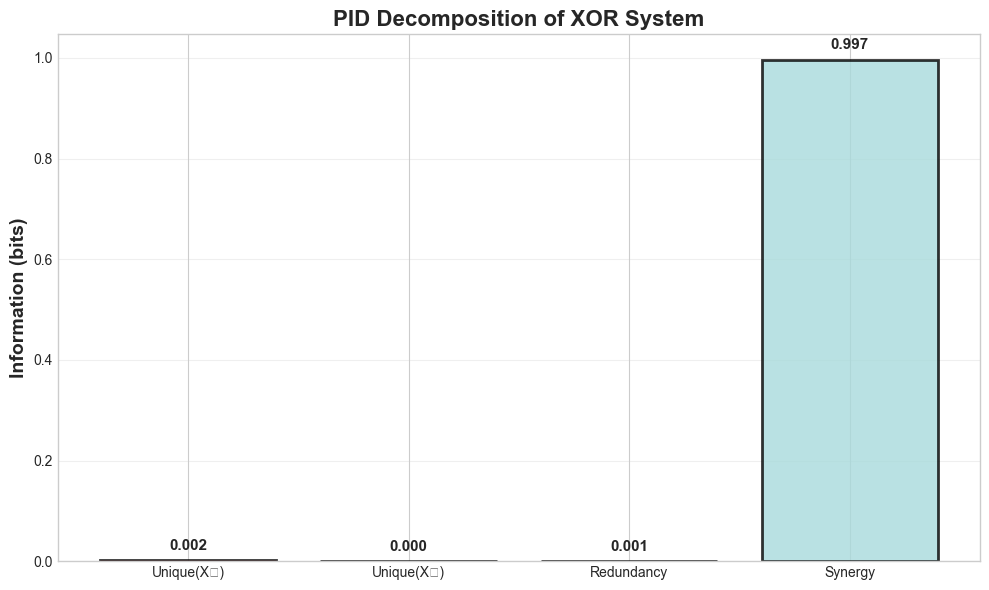

In [21]:
# HOI implements PID through redundancy and synergy metrics
# The PID classes need x (sources) and y (target) as SEPARATE arguments

def compute_pid_atoms(data):
    """
    Compute all four PID atoms for data with shape (n_samples, 3).
    Assumes data[:, 0] = X1, data[:, 1] = X2, data[:, 2] = Y
    
    Parameters:
    -----------
    data : array of shape (n_samples, 3)
        The three variables stacked column-wise
    
    Returns:
    --------
    dict with PID atoms and intermediate values
    """
    # Extract sources (X1, X2) and target (Y)
    # x should be (n_samples, n_sources) = (n_samples, 2)
    # y should be (n_samples,) or (n_samples, 1)
    x = data[:, :2]  # Sources: X1 and X2
    y = data[:, 2]   # Target: Y
    
    # Initialize models with BOTH x and y
    model_red = RedundancyMMI(x, y)
    model_syn = SynergyMMI(x, y)
    
    # Compute redundancy and synergy
    redundancy = float(model_red.fit(method='binning')[0])
    synergy = float(model_syn.fit(method='binning')[0])
    
    # For individual mutual informations, we compute them directly
    # I(X1; Y) 
    x1_y_data = np.column_stack([data[:, 0], data[:, 2]])
    model_mi1 = Oinfo(x1_y_data)
    # For 2 variables, TC = MI, so we can use that
    tc_x1_y = TC(x1_y_data)
    mi_x1_y = float(tc_x1_y.fit(method='binning')[0])
    
    # I(X2; Y)
    x2_y_data = np.column_stack([data[:, 1], data[:, 2]])
    tc_x2_y = TC(x2_y_data)
    mi_x2_y = float(tc_x2_y.fit(method='binning')[0])
    
    # Calculate unique informations
    # Unique(X1) = I(X1; Y) - Redundancy (bounded at 0)
    unique_x1 = max(0, mi_x1_y - redundancy)
    unique_x2 = max(0, mi_x2_y - redundancy)
    
    # Total = Unique1 + Unique2 + Redundancy + Synergy
    total = unique_x1 + unique_x2 + redundancy + synergy
    
    return {
        'unique_x1': unique_x1,
        'unique_x2': unique_x2,
        'redundancy': redundancy,
        'synergy': synergy,
        'total': total,
        'mi_x1_y': mi_x1_y,
        'mi_x2_y': mi_x2_y
    }

# Compute PID for XOR
print("PID Decomposition: XOR System")
print("=" * 60)
pid_xor = compute_pid_atoms(data_xor)

print("\nIndividual Mutual Informations:")
print(f"  I(X₁; Y) = {pid_xor['mi_x1_y']:.4f} bits")
print(f"  I(X₂; Y) = {pid_xor['mi_x2_y']:.4f} bits")
print(f"  I(X₁,X₂; Y) ≈ {pid_xor['total']:.4f} bits (from PID sum)")

print("\nPID Atoms:")
print(f"  Unique(X₁):  {pid_xor['unique_x1']:.4f} bits")
print(f"  Unique(X₂):  {pid_xor['unique_x2']:.4f} bits")
print(f"  Redundancy:  {pid_xor['redundancy']:.4f} bits")
print(f"  Synergy:     {pid_xor['synergy']:.4f} bits")

print("\n✨ Analysis:")
print("  For XOR, synergy should dominate!")
print("  Neither X₁ nor X₂ alone provides information about Y,")
print("  so unique informations should be ~0.")
print("  All information comes from knowing BOTH inputs together.")

# Visualize PID
fig, ax = plt.subplots(figsize=(10, 6))
atoms = ['Unique(X₁)', 'Unique(X₂)', 'Redundancy', 'Synergy']
values = [pid_xor['unique_x1'], pid_xor['unique_x2'], pid_xor['redundancy'], pid_xor['synergy']]
colors = ['#E63946', '#F1FAEE', '#457B9D', '#A8DADC']

bars = ax.bar(atoms, values, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax.set_ylabel('Information (bits)', fontsize=14, fontweight='bold')
ax.set_title('PID Decomposition of XOR System', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
            f'{val:.3f}', ha='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

### Visualizing PID Atoms

Let's create a comprehensive visualization showing how PID decomposes information for different systems:

Get list of multiplets
Get list of multiplets                                          
Get list of multiplets                                          
Get list of multiplets                                  
Get list of multiplets                                  


✓ Computed PID for XOR (Pure Synergy)


Get list of multiplets                                          
Get list of multiplets                                          
Get list of multiplets                                  


✓ Computed PID for COPY (Pure Redundancy)
⚠ Warning: Could not compute PID for AND (Mixed): data dtype should be integer. Check that you discretized your data. If so, use `data.astype(int)`


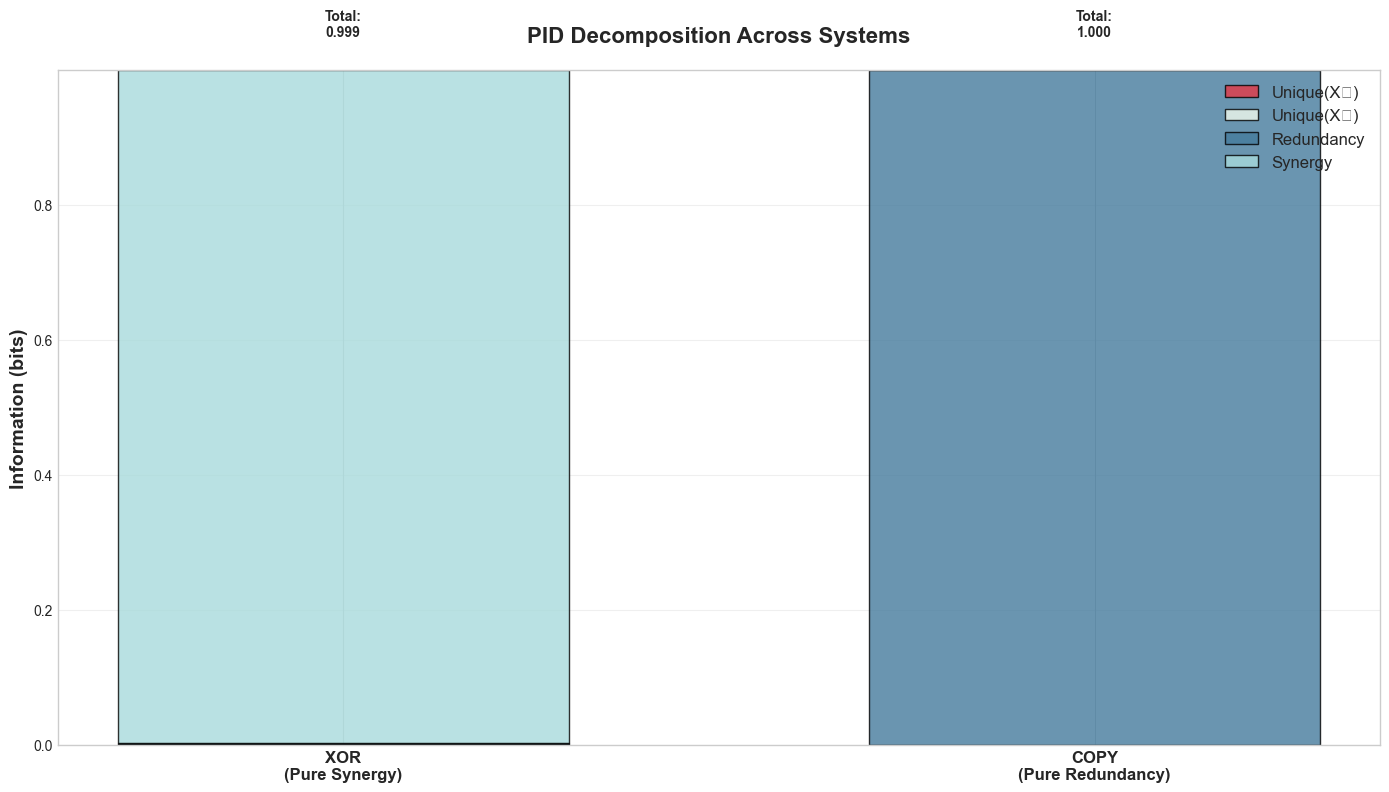


PID Summary Table:
System                       Unique1    Unique2     Redund    Synergy      Total
XOR (Pure Synergy)            0.0018     0.0000     0.0006     0.9969     0.9993
COPY (Pure Redundancy)        0.0000     0.0000     0.9997     0.0000     0.9997


In [22]:
# Compute PID for multiple systems
systems_pid = {
    'XOR\n(Pure Synergy)': data_xor,
    'COPY\n(Pure Redundancy)': data_copy,
}

# Add AND gate
X1_and = np.random.binomial(1, 0.5, n_samples)
X2_and = np.random.binomial(1, 0.5, n_samples)
Y_and = np.logical_and(X1_and, X2_and).astype(float)
systems_pid['AND\n(Mixed)'] = np.column_stack([X1_and, X2_and, Y_and])

# Compute PID for all
pid_results = {}
for name, data in systems_pid.items():
    try:
        pid_results[name] = compute_pid_atoms(data)
        print(f"✓ Computed PID for {name.replace(chr(10), ' ')}")
    except Exception as e:
        print(f"⚠ Warning: Could not compute PID for {name.replace(chr(10), ' ')}: {e}")
        continue

if len(pid_results) > 0:
    # Create stacked bar chart
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))

    names = list(pid_results.keys())
    x = np.arange(len(names))
    width = 0.6

    # Extract values for each atom
    unique1 = [pid_results[n]['unique_x1'] for n in names]
    unique2 = [pid_results[n]['unique_x2'] for n in names]
    redundancy = [pid_results[n]['redundancy'] for n in names]
    synergy = [pid_results[n]['synergy'] for n in names]

    # Create stacked bars
    p1 = ax.bar(x, unique1, width, label='Unique(X₁)', color='#E63946', alpha=0.8, edgecolor='black')
    p2 = ax.bar(x, unique2, width, bottom=unique1, label='Unique(X₂)', color='#F1FAEE', alpha=0.8, edgecolor='black')
    p3 = ax.bar(x, redundancy, width, bottom=np.array(unique1)+np.array(unique2), 
                label='Redundancy', color='#457B9D', alpha=0.8, edgecolor='black')
    p4 = ax.bar(x, synergy, width, bottom=np.array(unique1)+np.array(unique2)+np.array(redundancy), 
                label='Synergy', color='#A8DADC', alpha=0.8, edgecolor='black')

    # Labels and formatting
    ax.set_ylabel('Information (bits)', fontsize=14, fontweight='bold')
    ax.set_title('PID Decomposition Across Systems', fontsize=16, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(names, fontsize=12, fontweight='bold')
    ax.legend(fontsize=12, loc='upper right')
    ax.grid(True, alpha=0.3, axis='y')

    # Add total information labels
    for i, name in enumerate(names):
        total = pid_results[name]['total']
        ax.text(i, total + 0.05, f'Total:\n{total:.3f}', 
                ha='center', fontweight='bold', fontsize=10)

    plt.tight_layout()
    plt.show()

    # Print summary table
    print("\nPID Summary Table:")
    print("=" * 80)
    print(f"{'System':<25} {'Unique1':>10} {'Unique2':>10} {'Redund':>10} {'Synergy':>10} {'Total':>10}")
    print("=" * 80)
    for name in names:
        p = pid_results[name]
        name_clean = name.replace('\n', ' ')
        print(f"{name_clean:<25} {p['unique_x1']:>10.4f} {p['unique_x2']:>10.4f} "
              f"{p['redundancy']:>10.4f} {p['synergy']:>10.4f} {p['total']:>10.4f}")

## Part 5: Application to Simulated Neural Data

### Realistic Neural Population Scenario

Now let's apply everything we've learned to a more realistic neuroscience scenario. We'll simulate a small population of V1 neurons encoding visual orientation, then use HOI to discover their information structure.

**Scenario**:
- 10 V1 neurons
- 8 orientations (0°, 45°, 90°, 135°, 180°, 225°, 270°, 315°)
- 500 trials
- Each neuron has a preferred orientation
- Some neurons encode independently
- Some form synergistic pairs
- Some are redundant (overlapping tuning)

This mimics real V1 organization where neurons with similar orientation preferences cluster together (orientation columns).

V1 Population Generated
Shape: (10, 500) (neurons × trials)
Orientation values: [  0.  45.  90. 135. 180. 225. 270. 315.]°

Neuron properties (first 3):
  Neuron 0: pref=-8.5°, width=55.5°, max=52.7Hz
  Neuron 1: pref=20.9°, width=30.2°, max=48.8Hz
  Neuron 2: pref=65.7°, width=32.0°, max=52.7Hz


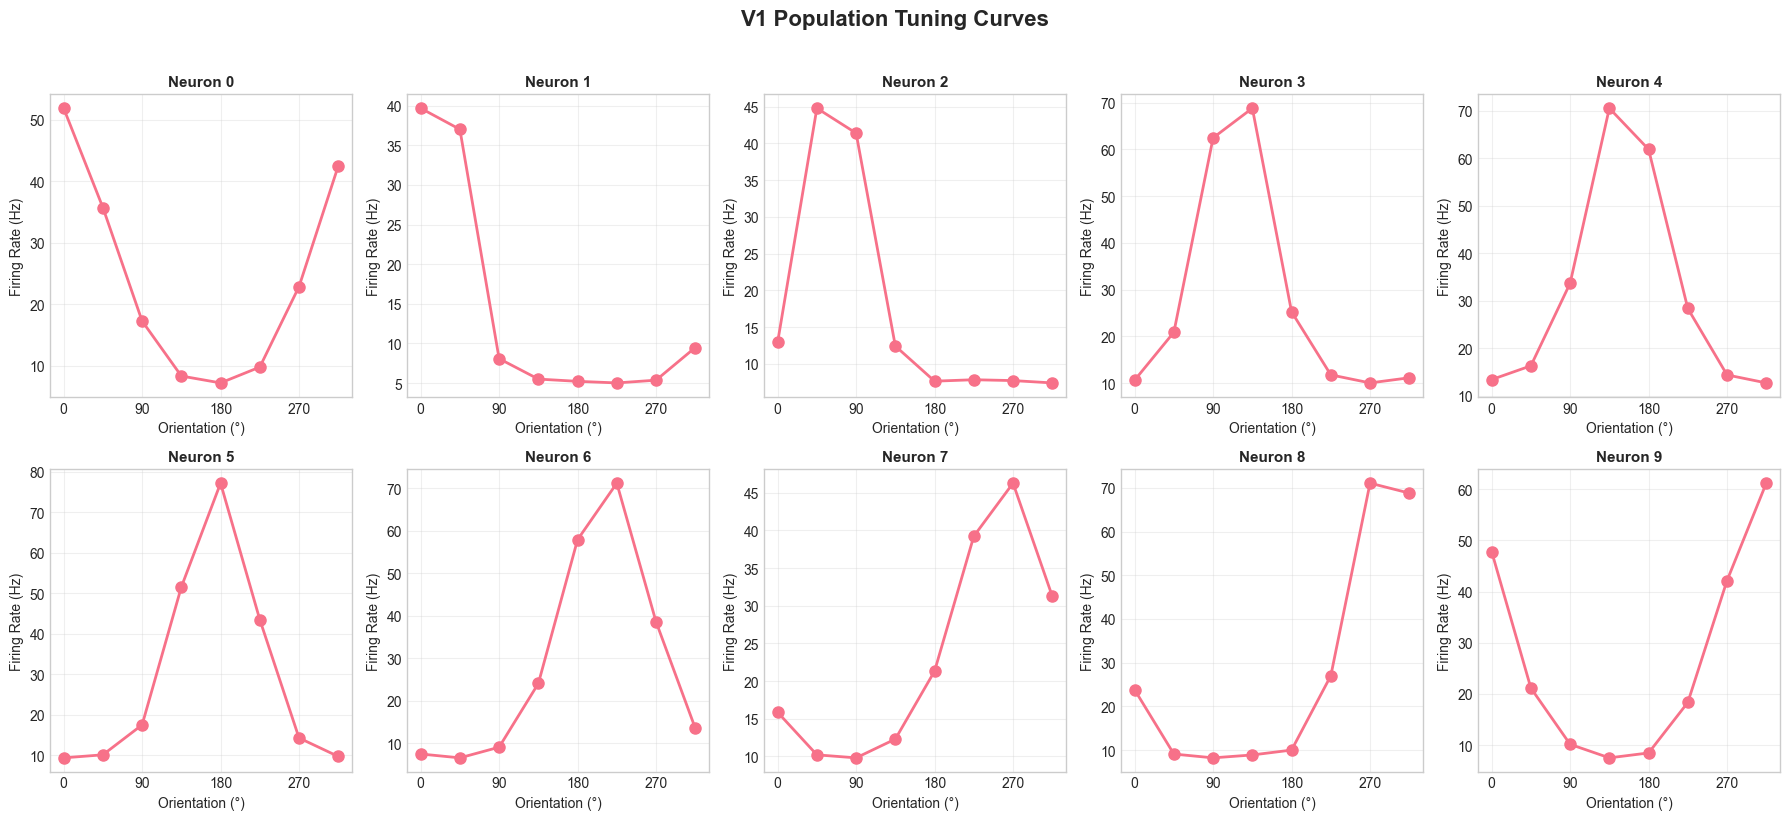


✓ Population exhibits realistic orientation selectivity
  Now let's discover the information structure...


In [23]:
def generate_v1_population(n_neurons=10, n_trials=500, n_orientations=8, seed=42):
    """
    Generate realistic V1 population responses with mixed information structure.
    
    Returns:
    --------
    responses : array (n_neurons, n_trials)
        Neural responses (spike counts)
    orientations : array (n_trials,)
        Stimulus orientation for each trial
    neuron_props : dict
        Properties of each neuron (preferred orientation, tuning width, etc.)
    """
    np.random.seed(seed)
    
    # Stimulus orientations
    ori_values = np.linspace(0, 360, n_orientations, endpoint=False)
    trial_oris = np.random.choice(ori_values, n_trials)
    
    # Initialize responses
    responses = np.zeros((n_neurons, n_trials))
    neuron_props = []
    
    for i in range(n_neurons):
        # Each neuron's parameters
        pref_ori = (i * 360 / n_neurons) + np.random.randn() * 10  # Slight jitter
        tuning_width = 30 + np.random.rand() * 30  # 30-60 degrees
        max_rate = 40 + np.random.rand() * 40  # 40-80 Hz
        baseline = 5 + np.random.rand() * 10  # 5-15 Hz
        noise_level = 0.3 + np.random.rand() * 0.4  # Variable noise
        
        neuron_props.append({
            'id': i,
            'pref_ori': pref_ori,
            'tuning_width': tuning_width,
            'max_rate': max_rate,
            'baseline': baseline
        })
        
        # Generate responses
        for j, ori in enumerate(trial_oris):
            # Angular distance
            dist = min(abs(ori - pref_ori), 360 - abs(ori - pref_ori))
            
            # Von Mises tuning
            tuning = np.exp(-(dist**2) / (2 * tuning_width**2))
            mean_rate = baseline + (max_rate - baseline) * tuning
            
            # Poisson variability
            responses[i, j] = np.random.poisson(mean_rate)
    
    return responses, trial_oris, neuron_props

# Generate population
responses, orientations, neuron_props = generate_v1_population()

print("V1 Population Generated")
print("=" * 60)
print(f"Shape: {responses.shape} (neurons × trials)")
print(f"Orientation values: {np.unique(orientations)}°")
print(f"\nNeuron properties (first 3):")
for i in range(3):
    prop = neuron_props[i]
    print(f"  Neuron {i}: pref={prop['pref_ori']:.1f}°, "
          f"width={prop['tuning_width']:.1f}°, max={prop['max_rate']:.1f}Hz")

# Visualize tuning curves
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

ori_vals = np.unique(orientations)
for i in range(10):
    ax = axes[i]
    
    # Compute mean response for each orientation
    mean_responses = []
    for ori in ori_vals:
        trials_this_ori = orientations == ori
        mean_resp = responses[i, trials_this_ori].mean()
        mean_responses.append(mean_resp)
    
    # Plot
    ax.plot(ori_vals, mean_responses, 'o-', linewidth=2, markersize=8)
    ax.set_xlabel('Orientation (°)', fontsize=10)
    ax.set_ylabel('Firing Rate (Hz)', fontsize=10)
    ax.set_title(f'Neuron {i}', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks([0, 90, 180, 270])

plt.suptitle('V1 Population Tuning Curves', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ Population exhibits realistic orientation selectivity")
print("  Now let's discover the information structure...")

### Discovering Synergistic Triplets

Now comes the exciting part: using HOI to automatically discover which triplets of neurons exhibit synergy. We'll scan through all possible triplets and find those with negative O-information.

    Copnorm and demean the data
Get list of multiplets


Data shape for HOI: (500, 10)
  - 500 samples (trials)
  - 10 features (neurons)

Scanning 120 possible triplets...
(This may take a minute)



O-Information Analysis Complete

Total triplets: 120
  Synergistic (O < -0.05): 40
  Independent (|O| ≤ 0.05): 35
  Redundant (O > 0.05): 45

Top 5 Most Synergistic Triplets:
1. Neurons [4, 6, 7]: O-info = -0.2586 bits
   Preferred orientations: ['151.8°', '213.4°', '260.9°']
2. Neurons [6, 7, 9]: O-info = -0.2380 bits
   Preferred orientations: ['213.4°', '260.9°', '320.0°']
3. Neurons [0, 3, 6]: O-info = -0.2216 bits
   Preferred orientations: ['-8.5°', '115.3°', '213.4°']
4. Neurons [5, 6, 8]: O-info = -0.2178 bits
   Preferred orientations: ['175.2°', '213.4°', '290.1°']
5. Neurons [0, 6, 8]: O-info = -0.2041 bits
   Preferred orientations: ['-8.5°', '213.4°', '290.1°']

Top 5 Most Redundant Triplets:
1. Neurons [0, 4, 5]: O-info = 0.3829 bits
   Preferred orientations: ['-8.5°', '151.8°', '175.2°']
2. Neurons [0, 4, 9]: O-info = 0.3668 bits
   Preferred orientations: ['-8.5°', '151.8°', '320.0°']
3. Neurons [4, 5, 9]: O-info = 0.3489 bits
   Preferred orientations: ['151.8°', '175

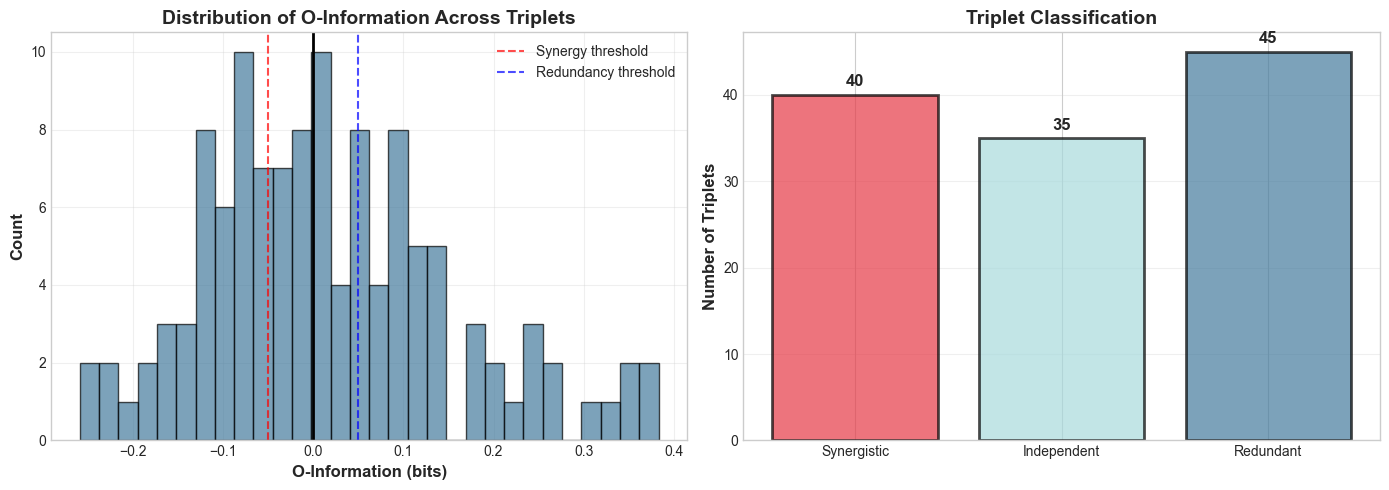

In [24]:
# Scan all triplets for synergy
# IMPORTANT: responses has shape (n_neurons, n_trials) from generate_v1_population
# We need to TRANSPOSE it to (n_trials, n_neurons) for HOI!
responses_transposed = responses.T  # Now (n_trials, n_neurons)

n_neurons = responses_transposed.shape[1]
all_triplets = list(combinations(range(n_neurons), 3))

print(f"Data shape for HOI: {responses_transposed.shape}")
print(f"  - {responses_transposed.shape[0]} samples (trials)")
print(f"  - {responses_transposed.shape[1]} features (neurons)")
print(f"\nScanning {len(all_triplets)} possible triplets...")
print("(This may take a minute)\n")

# Create model with transposed data
model_oinfo_v1 = Oinfo(responses_transposed)

# Compute O-information for all triplets
oinfo_values = model_oinfo_v1.fit(method='gc', minsize=3, maxsize=3)

# Convert to list for easier handling
oinfo_list = [float(v) for v in oinfo_values]

# Find synergistic and redundant triplets
synergy_threshold = -0.05  # bits
redundancy_threshold = 0.05  # bits

synergistic = [(trip, val) for trip, val in zip(all_triplets, oinfo_list) if val < synergy_threshold]
redundant = [(trip, val) for trip, val in zip(all_triplets, oinfo_list) if val > redundancy_threshold]
independent = [(trip, val) for trip, val in zip(all_triplets, oinfo_list) 
               if abs(val) <= max(abs(synergy_threshold), redundancy_threshold)]

# Sort by strength
synergistic.sort(key=lambda x: x[1])  # Most negative first
redundant.sort(key=lambda x: x[1], reverse=True)  # Most positive first

print("O-Information Analysis Complete")
print("=" * 60)
print(f"\nTotal triplets: {len(all_triplets)}")
print(f"  Synergistic (O < {synergy_threshold}): {len(synergistic)}")
print(f"  Independent (|O| ≤ {abs(synergy_threshold)}): {len(independent)}")
print(f"  Redundant (O > {redundancy_threshold}): {len(redundant)}")

# Show top synergistic triplets
print("\nTop 5 Most Synergistic Triplets:")
print("=" * 60)
for i, (triplet, oinfo) in enumerate(synergistic[:5]):
    neuron_ids = list(triplet)
    prefs = [neuron_props[n]['pref_ori'] for n in neuron_ids]
    print(f"{i+1}. Neurons {neuron_ids}: O-info = {oinfo:.4f} bits")
    print(f"   Preferred orientations: {[f'{p:.1f}°' for p in prefs]}")

# Show top redundant triplets
print("\nTop 5 Most Redundant Triplets:")
print("=" * 60)
for i, (triplet, oinfo) in enumerate(redundant[:5]):
    neuron_ids = list(triplet)
    prefs = [neuron_props[n]['pref_ori'] for n in neuron_ids]
    print(f"{i+1}. Neurons {neuron_ids}: O-info = {oinfo:.4f} bits")
    print(f"   Preferred orientations: {[f'{p:.1f}°' for p in prefs]}")

# Visualize distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(oinfo_list, bins=30, color='#457B9D', alpha=0.7, edgecolor='black')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=2)
ax1.axvline(x=synergy_threshold, color='red', linestyle='--', alpha=0.7, label='Synergy threshold')
ax1.axvline(x=redundancy_threshold, color='blue', linestyle='--', alpha=0.7, label='Redundancy threshold')
ax1.set_xlabel('O-Information (bits)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Count', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of O-Information Across Triplets', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Category breakdown
ax2 = axes[1]
categories = ['Synergistic', 'Independent', 'Redundant']
counts = [len(synergistic), len(independent), len(redundant)]
colors = ['#E63946', '#A8DADC', '#457B9D']
ax2.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Number of Triplets', fontsize=12, fontweight='bold')
ax2.set_title('Triplet Classification', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
for i, (cat, cnt) in enumerate(zip(categories, counts)):
    ax2.text(i, cnt + 1, str(cnt), ha='center', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

## Part 6: Computational Scaling and Practical Considerations

### The Combinatorial Explosion

As you just saw, we computed O-information for 120 triplets (10 choose 3). But what if we had 20 neurons? Or 100? The number of possible triplets grows **very quickly**:

- 10 neurons: 120 triplets
- 20 neurons: 1,140 triplets
- 50 neurons: 19,600 triplets
- 100 neurons: 161,700 triplets

And this is just for triplets! For 4-way interactions (quadruplets), the numbers are even larger.

### Strategies for Large Systems

When dealing with large neural populations, you need smart strategies:

1. **Pre-screening**: Use pairwise MI to identify interesting variable pairs first
2. **Hierarchical**: Start with triplets, only explore larger multiplets if warranted
3. **Sampling**: Randomly sample multiplets rather than exhaustive search
4. **GPU acceleration**: Use JAX's GPU capabilities for parallel computation
5. **Time windowing**: For time series, analyze shorter windows

Let's demonstrate some of these strategies:

    Copnorm and demean the data
Get list of multiplets


Benchmarking HOI Computation...



    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets
    Copnorm and demean the data                            
Get list of multiplets


Computational Scaling Analysis
Neurons    Multiplets   Time (s)     ms/multiplet   
5          10           0.1566       15.66          
10         50           0.0748       1.50           
15         50           0.0842       1.68           
20         50           0.0961       1.92           
30         50           0.1655       3.31           


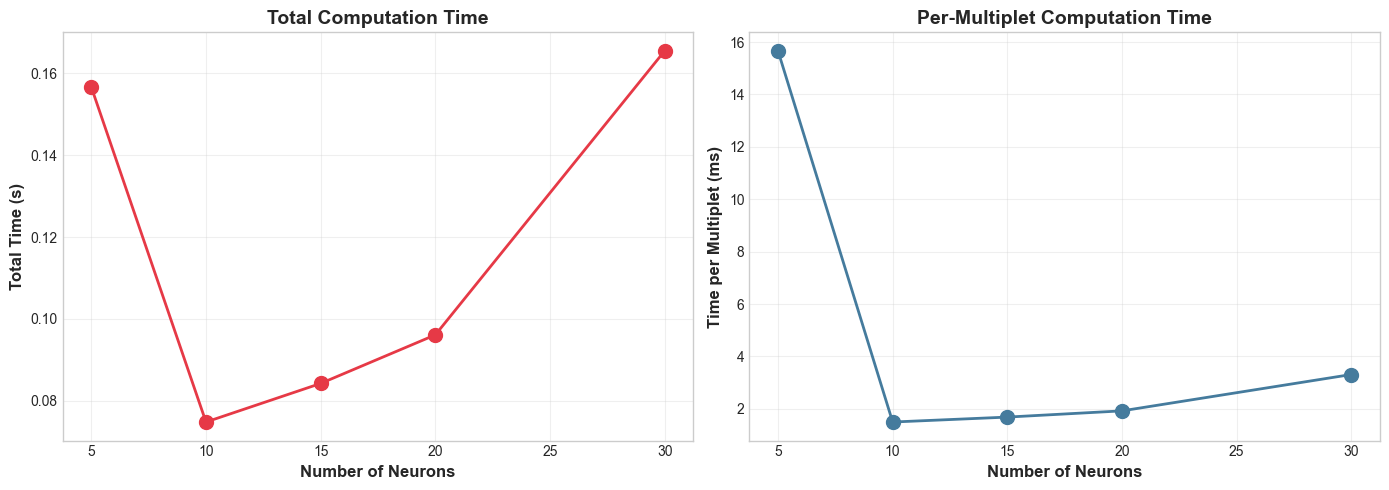


💡 Scaling Notes:
  - Time grows with number of neurons (more entropy calculations)
  - Time per multiplet is relatively constant
  - For large systems, sample multiplets rather than computing all


In [25]:
# Benchmark computation time vs system size
import time

def benchmark_hoi(n_neurons_list, n_samples=1000, n_multiplets=50):
    """
    Measure HOI computation time for different system sizes.
    """
    results = []
    
    for n_neurons in n_neurons_list:
        # Generate random data in correct format: (n_samples, n_features)
        data = np.random.randn(n_samples, n_neurons)
        
        # Sample multiplets
        all_trips = list(combinations(range(n_neurons), 3))
        if len(all_trips) > n_multiplets:
            sampled_trips = [all_trips[i] for i in 
                           np.random.choice(len(all_trips), n_multiplets, replace=False)]
        else:
            sampled_trips = all_trips
        
        # Create model WITH DATA
        model = Oinfo(data)
        
        # Time the computation
        start = time.time()
        oinfo = model.fit(method='gc', minsize=3, maxsize=3)
        elapsed = time.time() - start
        
        results.append({
            'n_neurons': n_neurons,
            'n_multiplets': len(sampled_trips),
            'time': elapsed,
            'time_per_multiplet': elapsed / len(sampled_trips)
        })
    
    return results

# Test different sizes
sizes = [5, 10, 15, 20, 30]
print("Benchmarking HOI Computation...\n")
benchmark_results = benchmark_hoi(sizes)

# Display results
print("Computational Scaling Analysis")
print("=" * 70)
print(f"{'Neurons':<10} {'Multiplets':<12} {'Time (s)':<12} {'ms/multiplet':<15}")
print("=" * 70)
for res in benchmark_results:
    print(f"{res['n_neurons']:<10} {res['n_multiplets']:<12} "
          f"{res['time']:<12.4f} {res['time_per_multiplet']*1000:<15.2f}")

# Visualize scaling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

neurons = [r['n_neurons'] for r in benchmark_results]
times = [r['time'] for r in benchmark_results]
time_per = [r['time_per_multiplet']*1000 for r in benchmark_results]

# Total time
ax1.plot(neurons, times, 'o-', linewidth=2, markersize=10, color='#E63946')
ax1.set_xlabel('Number of Neurons', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Time (s)', fontsize=12, fontweight='bold')
ax1.set_title('Total Computation Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Time per multiplet
ax2.plot(neurons, time_per, 'o-', linewidth=2, markersize=10, color='#457B9D')
ax2.set_xlabel('Number of Neurons', fontsize=12, fontweight='bold')
ax2.set_ylabel('Time per Multiplet (ms)', fontsize=12, fontweight='bold')
ax2.set_title('Per-Multiplet Computation Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n💡 Scaling Notes:")
print("  - Time grows with number of neurons (more entropy calculations)")
print("  - Time per multiplet is relatively constant")
print("  - For large systems, sample multiplets rather than computing all")

## Summary and Key Takeaways

### What We've Accomplished

Congratulations! You've gone from manual calculations in Notebooks 1-2 to using a professional package for higher-order interaction analysis. You now know how to:

1. **Install and configure HOI** with the right estimators
2. **Compute O-information** to detect synergy vs redundancy
3. **Apply PID** to decompose information into four atoms
4. **Use multiple estimators** and understand their trade-offs
5. **Analyze realistic neural data** to discover information structure
6. **Understand computational scaling** and plan analyses appropriately

### When to Use Each HOI Measure

**O-Information (`Oinfo`)**:
- **Use for**: Quick screening to identify synergistic or redundant multiplets
- **Advantages**: Fast, single number, clear interpretation
- **Limitations**: Doesn't decompose into unique/redundant/synergistic components

**PID (RedundancyMMI + SynergyMMI)**:
- **Use for**: Detailed understanding of information structure (2 sources only)
- **Advantages**: Complete decomposition into interpretable atoms
- **Limitations**: Only well-defined for 2 sources, computationally expensive

**Total Correlation (`TC`)**:
- **Use for**: Measuring overall system integration
- **Advantages**: Always non-negative, intuitive
- **Limitations**: Doesn't distinguish synergy from redundancy

### Critical Reminders

**Data Format**: HOI expects (n_features, n_samples) - opposite of scikit-learn!

**Estimator Choice**: Use 'gc' (Gaussian Copula) as default unless you have specific reasons otherwise.

**Statistical Significance**: HOI doesn't include built-in significance testing. For that, use Frites (next notebook) or implement permutation tests.

**Interpretation**: Always report both sign AND magnitude of O-information.

**Computational Planning**: For large systems (50+ variables), use sampling or hierarchical strategies.

### The Bigger Picture

HOI has revealed something profound about your V1 population: some neuron triplets carry information synergistically (their combination predicts better than the sum of individuals), while others are redundant (they duplicate information for robustness).

This isn't just a mathematical curiosity - it reflects the **functional organization** of neural circuits. Synergistic triplets might correspond to neurons within the same orientation column working together. Redundant triplets might provide robustness against noise or damage.

### Bridge to Notebook 4

HOI is excellent for analyzing static snapshots of neural activity. But real neural data is **dynamic** - it evolves over time during tasks. In Notebook 4, we'll use **Frites** to:
- Compute **time-resolved** mutual information
- Track how information flows during cognitive tasks
- Perform **statistical testing** with permutations
- Analyze **dynamic functional connectivity**
- Handle **multi-subject** designs properly

Frites complements HOI by adding temporal dynamics and rigorous statistics. Together, they provide a complete toolkit for information-theoretic analysis of neural data.

See you in Notebook 4! 🚀

## Practice Exercises

Before moving to Notebook 4, try these exercises to solidify your understanding:

In [26]:
print("PRACTICE EXERCISES")
print("=" * 70)

print("\n1. Create an OR gate (Y = X₁ OR X₂) and compute its O-information.")
print("   Will it be synergistic, redundant, or independent?")
print("   Hint: Think about what happens when both inputs are 1")

print("\n2. Modify the V1 simulation to have 15 neurons instead of 10.")
print("   How does the distribution of O-information values change?")
print("   Are there more or fewer synergistic triplets?")

print("\n3. Compare PID decomposition for AND gate vs OR gate.")
print("   Which has more redundancy? Which has more synergy?")
print("   Can you explain why based on the logic?")

print("\n4. Test different estimators ('gc', 'gauss', 'binning') on Gaussian data.")
print("   When is 'gauss' estimator most accurate?")
print("   When does it fail?")

print("\n5. Add noise to the XOR system: flip Y with 30% probability.")
print("   How does this affect:")
print("   - O-information magnitude?")
print("   - PID decomposition?")
print("   - Does synergy decrease linearly with noise?")

print("\n" + "=" * 70)
print("Try these exercises in a new cell below!")
print("Solutions are in the notebook repository.")
print("=" * 70)

PRACTICE EXERCISES

1. Create an OR gate (Y = X₁ OR X₂) and compute its O-information.
   Will it be synergistic, redundant, or independent?
   Hint: Think about what happens when both inputs are 1

2. Modify the V1 simulation to have 15 neurons instead of 10.
   How does the distribution of O-information values change?
   Are there more or fewer synergistic triplets?

3. Compare PID decomposition for AND gate vs OR gate.
   Which has more redundancy? Which has more synergy?
   Can you explain why based on the logic?

4. Test different estimators ('gc', 'gauss', 'binning') on Gaussian data.
   When is 'gauss' estimator most accurate?
   When does it fail?

5. Add noise to the XOR system: flip Y with 30% probability.
   How does this affect:
   - O-information magnitude?
   - PID decomposition?
   - Does synergy decrease linearly with noise?

Try these exercises in a new cell below!
Solutions are in the notebook repository.


## Further Resources

### HOI Documentation
- **Main documentation**: https://brainets.github.io/hoi/
- **GitHub repository**: https://github.com/brainets/hoi
- **Tutorial examples**: Check the examples gallery

### Key Papers on PID
1. **Williams & Beer (2010)** - "Nonnegative Decomposition of Multivariate Information"
   - Original PID framework
   - Defines the four atoms

2. **Bertschinger et al. (2014)** - "Quantifying Unique Information"
   - BROJA measure
   - Game-theoretic formulation

3. **Timme et al. (2014)** - "Synergy, redundancy, and multivariate information measures"
   - Comprehensive review
   - Comparison of different PID measures

### Related Packages
- **dit**: Discrete information theory (Python)
- **IDTxl**: Information dynamics (transfer entropy)
- **JIDT**: Java Information Dynamics Toolkit
- **Frites**: Next notebook!

### Advanced Topics
- **Multiplet expansion**: Beyond triplets
- **Directed information**: Causal structures
- **Information geometry**: Geometric interpretation
- **Integrated Information Theory (IIT)**: Consciousness and Φ

Happy exploring! 🎉